In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import os
import warnings

from IPython import display 
display.set_matplotlib_formats('svg')
warnings.filterwarnings('ignore')

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/DATA/amazon_review_full_csv/
# !pwd

/content/drive/My Drive/DATA/amazon_review_full_csv


In [4]:
column_names=["rating","title",'review']

In [5]:
df = pd.read_csv('train.csv', names=column_names)

In [6]:
df.head()

,rating,title,review
0,3,more like funchuck,Gave this to my dad for a gag gift after direc...
1,5,Inspiring,I hope a lot of people hear this cd. We need m...
2,5,The best soundtrack ever to anything.,I'm reading a lot of reviews saying that this ...
3,4,Chrono Cross OST,The music of Yasunori Misuda is without questi...
4,5,Too good to be true,Probably the greatest soundtrack in history! U...


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 3 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   rating  int64 
 1   title   object
 2   review  object
dtypes: int64(1), object(2)
memory usage: 68.7+ MB


In [8]:
df = df[['review', 'rating']]
df.head()

,review,rating
0,Gave this to my dad for a gag gift after direc...,3
1,I hope a lot of people hear this cd. We need m...,5
2,I'm reading a lot of reviews saying that this ...,5
3,The music of Yasunori Misuda is without questi...,4
4,Probably the greatest soundtrack in history! U...,5


In [9]:
df = df.iloc[0:60000, :]

In [10]:
df.shape

(60000, 2)

In [11]:
df.isnull().sum()

review    0
rating    0
dtype: int64

In [12]:
df['rating'].value_counts()

3    12390
5    12177
4    12151
2    11974
1    11308
Name: rating, dtype: int64

In [13]:
# if rating is above 3 we will consider it as 1 else 0.
df["rating"] = df["rating"].apply(lambda x: 1 if x < 3  else 0) # positive as 0 and negative as 1

In [14]:
df['rating'].value_counts()

0    36718
1    23282
Name: rating, dtype: int64

In [15]:
df0 = df[df['rating'] == 0].iloc[0:20000, :]

In [16]:
df1 = df[df['rating'] == 1].iloc[0:20000, :]

In [17]:
df = pd.concat([df0, df1])

In [18]:
#sentiment count
df['rating'].value_counts()

0    20000
1    20000
Name: rating, dtype: int64

We can see that the dataset is balanced now.



Before we start building model, we need to pre-process the text.

**Pre-processing**

Text normalization

In [19]:
  >>> import nltk
  >>> nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

Removing html strips and noise text



In [21]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

In [22]:
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

Removing special characters



In [23]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

In [24]:
#Apply function on review column
df['review']=df['review'].apply(remove_special_characters)

Text stemming



In [25]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

In [26]:
#Apply function on review column
df['review']=df['review'].apply(simple_stemmer)

Removing stopwords

In [27]:
#set stopwords to english
stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

{"wasn't", "haven't", 'myself', 'its', 'doing', 'himself', 'or', 'where', 'being', 't', 'from', 've', 'once', 'through', 'on', 'both', 'had', 's', 'can', 'ma', 'each', 'the', 'aren', 'with', "shan't", 'too', 'we', 'when', 'were', 're', 'shouldn', 'you', 'by', "don't", 'yourselves', 'been', 'd', 'm', 'her', 'while', 'our', 'your', 'shan', 'whom', 'be', 'having', 'couldn', 'mightn', 'did', 'during', 'any', 'them', 'if', 'nor', 'same', 'no', 'don', 'not', 'wouldn', 'and', 'their', 'down', 'some', 'under', 'haven', "shouldn't", "you'll", 'again', "hadn't", "you've", 'all', 'hers', 'most', 'then', 'how', 'will', 'an', 'hasn', 'more', 'off', 'am', 'is', 'ours', 'should', 'him', "hasn't", "mightn't", 'in', 'than', 'mustn', 'this', "you're", "doesn't", 'of', "couldn't", 'me', 'he', "it's", 'below', 'doesn', 'isn', 'further', 'now', 'themselves', 'few', 'for', "aren't", 'there', "should've", 'are', 'why', 'so', "isn't", 'herself', 'as', 'i', 'to', 'other', 'yours', 'my', 'only', 'against', 'doe

In [28]:
#Apply function on review column
df['review']=df['review'].apply(remove_stopwords)

Text to Words

1. Bag of Words

In [29]:
# data split 
from sklearn.model_selection import train_test_split 
v, xtest, ytrain, ytest = train_test_split(df['review'], df['rating'], test_size = 0.3)

In [30]:
# Convert text to numbers using (BOW)! 
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

# let's convert 
xtrain_bow = vectorizer.fit_transform(xtrain).toarray()
xtest_bow = vectorizer.transform(xtest).toarray()

In [31]:
print('BOW_cv_train:',xtrain_bow.shape)
print('BOW_cv_test:',xtest_bow.shape)

BOW_cv_train: (28000, 60099)
BOW_cv_test: (12000, 60099)


2. TF-IDF

In [32]:
# Convert text to numbers using (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer  

tf_vectorizer = TfidfVectorizer()

# let's convert 
xtrain_tf = tf_vectorizer.fit_transform(xtrain).toarray()
xtest_tf = tf_vectorizer.transform(xtest).toarray()

In [33]:
print('Tfidf_train:',xtrain_tf.shape)
print('Tfidf_test:',xtest_tf.shape)

Tfidf_train: (28000, 60099)
Tfidf_test: (12000, 60099)


### **Model Building**

**Logistic regression model**

Let us build logistic regression model for both bag of words and tfidf features

In [34]:
#training the model
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(xtrain_bow,ytrain)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(xtrain_tf,ytrain)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


In [35]:
#Predicting the model for bag of words
lr_bow_predict=lr.predict(xtest_bow)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(xtest_tf)
print(lr_tfidf_predict)

[1 1 0 ... 0 1 1]
[0 1 0 ... 0 1 1]


Accuracy of the model

In [36]:
#Accuracy score for bag of words
lr_bow_score=accuracy_score(ytest,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(ytest,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.759
lr_tfidf_score : 0.7739166666666667


In [39]:
# let's check our model! 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 

def metrics(prediction, actual): 
    print('Confusion_matrix \n', confusion_matrix(actual, prediction))
    print('\nAccuracy:', accuracy_score(actual, prediction))
    print('\nclassification_report\n')
    print(classification_report(actual, prediction))

In [40]:
metrics(lr_bow_predict, ytest)

Confusion_matrix 
 [[4282 1696]
 [1196 4826]]

Accuracy: 0.759

classification_report

              precision    recall  f1-score   support

           0       0.78      0.72      0.75      5978
           1       0.74      0.80      0.77      6022

    accuracy                           0.76     12000
   macro avg       0.76      0.76      0.76     12000
weighted avg       0.76      0.76      0.76     12000



In [41]:
metrics(lr_tfidf_predict, ytest)

Confusion_matrix 
 [[4625 1353]
 [1360 4662]]

Accuracy: 0.7739166666666667

classification_report

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      5978
           1       0.78      0.77      0.77      6022

    accuracy                           0.77     12000
   macro avg       0.77      0.77      0.77     12000
weighted avg       0.77      0.77      0.77     12000



Gaussina NB model

In [42]:
from sklearn.naive_bayes import GaussianNB

# USING BOW 
clf_bow = GaussianNB().fit(xtrain_bow, ytrain)  # fitting 
prediction_bow = clf_bow.predict(xtest_bow)  # predictions

# USINGN TFIDF 
clf_tf = GaussianNB().fit(xtrain_tf, ytrain)
prediction_tf = clf_tf.predict(xtest_tf)

In [43]:
metrics(prediction_bow, ytest)

Confusion_matrix 
 [[2172 3806]
 [1307 4715]]

Accuracy: 0.5739166666666666

classification_report

              precision    recall  f1-score   support

           0       0.62      0.36      0.46      5978
           1       0.55      0.78      0.65      6022

    accuracy                           0.57     12000
   macro avg       0.59      0.57      0.55     12000
weighted avg       0.59      0.57      0.55     12000



In [44]:
metrics(prediction_tf, ytest)

Confusion_matrix 
 [[2425 3553]
 [1527 4495]]

Accuracy: 0.5766666666666667

classification_report

              precision    recall  f1-score   support

           0       0.61      0.41      0.49      5978
           1       0.56      0.75      0.64      6022

    accuracy                           0.58     12000
   macro avg       0.59      0.58      0.56     12000
weighted avg       0.59      0.58      0.56     12000



Stochastic gradient descent or Linear support vector machines for bag of words and tfidf features

In [45]:
#training the linear svm
svm=SGDClassifier(loss='hinge',max_iter=500,random_state=42)
#fitting the svm for bag of words
svm_bow=svm.fit(xtrain_bow,ytrain)
print(svm_bow)
#fitting the svm for tfidf features
svm_tfidf=svm.fit(xtrain_tf,ytrain)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


Model performance on test data



In [46]:
#Predicting the model for bag of words
svm_bow_predict=svm.predict(xtest_bow)
print(svm_bow_predict)
#Predicting the model for tfidf features
svm_tfidf_predict=svm.predict(xtest_tf)
print(svm_tfidf_predict)

[1 1 0 ... 0 1 1]
[0 1 0 ... 0 1 1]


Accuracy of the model



In [47]:
metrics(svm_bow_predict, ytest)

Confusion_matrix 
 [[4272 1706]
 [1197 4825]]

Accuracy: 0.7580833333333333

classification_report

              precision    recall  f1-score   support

           0       0.78      0.71      0.75      5978
           1       0.74      0.80      0.77      6022

    accuracy                           0.76     12000
   macro avg       0.76      0.76      0.76     12000
weighted avg       0.76      0.76      0.76     12000



In [48]:
metrics(svm_tfidf_predict, ytest)

Confusion_matrix 
 [[4704 1274]
 [1438 4584]]

Accuracy: 0.774

classification_report

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      5978
           1       0.78      0.76      0.77      6022

    accuracy                           0.77     12000
   macro avg       0.77      0.77      0.77     12000
weighted avg       0.77      0.77      0.77     12000



Multinomial Naive Bayes for bag of words and tfidf features


In [49]:
#training the model
mnb=MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(xtrain_bow,ytrain)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(xtrain_tf,ytrain)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


Model performance on test data

In [50]:
#Predicting the model for bag of words
mnb_bow_predict=mnb.predict(xtest_bow)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(xtest_tf)
print(mnb_tfidf_predict)

[0 1 0 ... 0 1 1]
[0 1 0 ... 0 1 1]


Accuracy of the model

In [51]:
metrics(mnb_bow_predict, ytest)

Confusion_matrix 
 [[4322 1656]
 [1206 4816]]

Accuracy: 0.7615

classification_report

              precision    recall  f1-score   support

           0       0.78      0.72      0.75      5978
           1       0.74      0.80      0.77      6022

    accuracy                           0.76     12000
   macro avg       0.76      0.76      0.76     12000
weighted avg       0.76      0.76      0.76     12000



In [52]:
metrics(mnb_tfidf_predict, ytest)

Confusion_matrix 
 [[4335 1643]
 [1303 4719]]

Accuracy: 0.7545

classification_report

              precision    recall  f1-score   support

           0       0.77      0.73      0.75      5978
           1       0.74      0.78      0.76      6022

    accuracy                           0.75     12000
   macro avg       0.76      0.75      0.75     12000
weighted avg       0.76      0.75      0.75     12000



**Visualize words using WordCloud**


In [67]:
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image  

# get the text based on ratings! 
rating_zero = df['review'][df['rating'] == 0]
rating_one = df['review'][df['rating'] == 1]


# word tokenize the data 
def list_tokenizer(rating): 
    ratings = " ".join(rating)
    ratings = nltk.word_tokenize(ratings)
    return str(ratings)

# visualizer 
def word_cloud(rating, number): 
    wc = WordCloud(background_color = 'black', max_font_size = 50, max_words = 500)  
    wc.generate(rating)  
    plt.figure(figsize=(10,8))
    plt.imshow(wc, interpolation = 'bilinear')  
    plt.title(f'WordCloud for {number}')
    plt.axis('off');

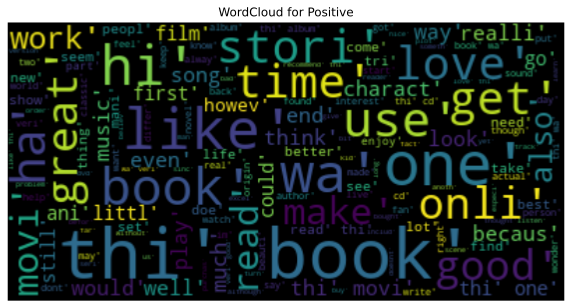

In [69]:
# Let's visuailze the ratings

word_cloud(list_tokenizer(rating_zero), 'Positive')

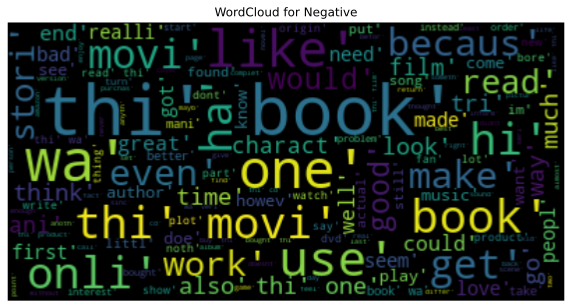

In [70]:
word_cloud(list_tokenizer(rating_one), 'Negative')